## Accelerator strategy

In [1]:
import tensorflow as tf
import os

# Detect hardware
try:
    # Check for TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Check for GPU(s)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print(f'Running on {len(gpus)} GPUs')
    else:
        strategy = tf.distribute.get_strategy()
        print('Running on single GPU or CPU')

print("Number of accelerators: ", strategy.num_replicas_in_sync)

# Configure for Kaggle
if os.path.exists('/kaggle'):
    print("Running in Kaggle environment")


2025-11-29 09:44:19.641579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764409459.819841      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764409459.866906      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Running on single GPU or CPU
Number of accelerators:  1
Running in Kaggle environment


## Unsupervised dataloader

In [1]:
# !pip install polars
# !pip install keras-tuner

import polars as pl
import numpy as np
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence


class UnsupervisedNFLDataLoader:
    """Loads NFL data for unsupervised learning (no trajectory labels needed).
    
    This loader processes ALL player sequences (player_to_predict=True and False)
    to maximize the amount of training data for representation learning.
    """
    
    def __init__(self):
        self.input_sequences = None
        
    def load_files(self, directories, include_labeled=True, include_unlabeled=True, normalize=False):
        """Load input files from specified directories.
        
        Args:
            directories (list): List of directory paths to load from
            include_labeled (bool): Include player_to_predict=True sequences
            include_unlabeled (bool): Include player_to_predict=False sequences
            normalize (bool): Whether to normalize features (Z-score)
        """
        input_dfs = []
        
        print(f"Loading unsupervised data from {len(directories)} directories...")
        print(f"Include labeled: {include_labeled}, Include unlabeled: {include_unlabeled}")
        
        for d in directories:
            if not os.path.exists(d):
                print(f"Warning: Directory not found: {d}")
                continue
                
            input_files = sorted([f for f in os.listdir(d) if f.startswith('input') and f.endswith('.csv')])
            print(f"  Found {len(input_files)} input files in {d}")
            
            for f in input_files:
                try:
                    df = pl.read_csv(os.path.join(d, f), infer_schema_length=10000)
                    
                    initial_rows = len(df)
                    
                    # Filter based on player_to_predict flag
                    if "player_to_predict" in df.columns:
                        if include_labeled and not include_unlabeled:
                            # Only labeled
                            if df["player_to_predict"].dtype == pl.Boolean:
                                df = df.filter(pl.col("player_to_predict") == True)
                            else:
                                df = df.filter(pl.col("player_to_predict").cast(pl.Utf8).str.to_lowercase() == "true")
                        elif include_unlabeled and not include_labeled:
                            # Only unlabeled
                            if df["player_to_predict"].dtype == pl.Boolean:
                                df = df.filter(pl.col("player_to_predict") == False)
                            else:
                                df = df.filter(pl.col("player_to_predict").cast(pl.Utf8).str.to_lowercase() == "false")
                        # If both True, include all (no filtering)
                    
                    if len(df) > 0:
                        input_dfs.append(df)
                        print(f"    {f}: {initial_rows} -> {len(df)} rows")
                        
                except Exception as e:
                    print(f"Error loading {f}: {e}")
        
        if not input_dfs:
            print("No data found.")
            self.input_sequences = pl.DataFrame()
            return
        
        # Concatenate all dataframes
        print("Concatenating dataframes...")
        full_input = pl.concat(input_dfs, how="vertical_relaxed")
        
        # Deduplicate
        full_input = full_input.unique(subset=["game_id", "play_id", "nfl_id", "frame_id"])
        
        # Process features
        print("Processing features...")
        id_cols = ["game_id", "play_id", "nfl_id", "frame_id", "player_to_predict", "time"]
        feature_cols = [c for c in full_input.columns if c not in id_cols]
        
        expressions = []
        for col in feature_cols:
            if full_input[col].dtype == pl.Utf8:
                expr = (
                    pl.when(pl.col(col).str.to_lowercase() == "true").then(1.0)
                    .when(pl.col(col).str.to_lowercase() == "false").then(0.0)
                    .when(pl.col(col).str.to_lowercase() == "left").then(0.0)
                    .when(pl.col(col).str.to_lowercase() == "right").then(1.0)
                    .when(pl.col(col).str.to_lowercase() == "defense").then(0.0)
                    .when(pl.col(col).str.to_lowercase() == "offense").then(1.0)
                    .otherwise(
                        pl.col(col).cast(pl.Float64, strict=False).fill_null(
                            pl.col(col).hash() % 10000
                        )
                    ).cast(pl.Float64).alias(col)
                )
                expressions.append(expr)
            else:
                expressions.append(pl.col(col).cast(pl.Float64).alias(col))
        
        full_input = full_input.with_columns(expressions)
        
        # Sort by frame_id
        if "frame_id" in full_input.columns:
            full_input = full_input.sort(["game_id", "play_id", "nfl_id", "frame_id"])
            
        # Normalize features if requested
        if normalize:
            print("Normalizing features (Z-score)...")
            norm_exprs = []
            for col in feature_cols:
                # Check for constant columns to avoid division by zero
                n_unique = full_input.select(pl.col(col).n_unique()).item()
                if n_unique > 1:
                    norm_exprs.append(
                        ((pl.col(col) - pl.col(col).mean()) / (pl.col(col).std() + 1e-8)).alias(col)
                    )
            
            if norm_exprs:
                full_input = full_input.with_columns(norm_exprs)
        
        # Group into sequences
        agg_exprs = [pl.col(c) for c in feature_cols]
        self.input_sequences = full_input.group_by(
            ["game_id", "play_id", "nfl_id"], 
            maintain_order=True
        ).agg(agg_exprs)
        
        print(f"Total sequences: {len(self.input_sequences)}")
        
        # Debug sequence lengths
        if len(self.input_sequences) > 0:
            lengths = self.input_sequences.select(pl.col(feature_cols[0]).list.len()).to_series()
            print(f"Sequence length stats: min={lengths.min()}, max={lengths.max()}, mean={lengths.mean():.2f}")

        
    def get_sequences(self):
        """Convert sequences to numpy arrays.
        
        Returns:
            np.ndarray: Array of input sequences (object array)
        """
        if self.input_sequences is None or self.input_sequences.is_empty():
            return np.array([])
        
        print("Converting to NumPy arrays...")
        
        # Get feature columns (exclude keys)
        input_cols = [c for c in self.input_sequences.columns 
                     if c not in ["game_id", "play_id", "nfl_id"]]
        
        # Convert to sequences
        input_col_indices = [self.input_sequences.columns.index(c) for c in input_cols]
        rows = self.input_sequences.iter_rows()
        
        X_list = []
        for row in rows:
            feature_seqs = [row[i] for i in input_col_indices]
            # Convert to numpy array to ensure consistent shape (T, F)
            X_seq = np.array(list(zip(*feature_seqs)), dtype=np.float32)
            if len(X_seq) > 0:
                X_list.append(X_seq)
        
        X = np.array(X_list, dtype=object)
        print(f"Loaded {len(X)} sequences")
        
        return X


class UnsupervisedNFLSequence(Sequence):
    """Keras Sequence for unsupervised learning on NFL data.
    
    For autoencoder: input and output are the same (reconstruction)
    For next-step prediction: input is sequence[:-n], output is sequence[n:]
    """
    
    def __init__(self, X, batch_size=32, maxlen=None, shuffle=True, 
                 task='autoencoder', prediction_steps=1):
        """Initialize the sequence.
        
        Args:
            X: Input sequences
            batch_size: Batch size
            maxlen: Maximum sequence length (auto-detect if None)
            shuffle: Whether to shuffle
            task: 'autoencoder' or 'next_step'
            prediction_steps: For next_step, how many steps ahead to predict
        """
        self.X = X
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.task = task
        self.prediction_steps = prediction_steps
        self.indices = np.arange(len(self.X))
        
        # Determine max length
        if maxlen is None:
            self.maxlen = max(len(seq) for seq in X)
        else:
            self.maxlen = maxlen
        
        print(f"UnsupervisedNFLSequence initialized:")
        print(f"  Samples: {len(self.X)}")
        print(f"  Batch size: {batch_size}")
        print(f"  Max length: {self.maxlen}")
        print(f"  Task: {task}")
        
        if self.task == 'next_step':
            if self.maxlen <= self.prediction_steps:
                raise ValueError(
                    f"Invalid configuration: maxlen ({self.maxlen}) must be greater than "
                    f"prediction_steps ({self.prediction_steps}) for 'next_step' task.\n"
                    f"Please increase maxlen or decrease prediction_steps."
                )
            
            # Ensure we don't produce 0-length sequences even if maxlen is technically larger but close
            effective_len = self.maxlen - self.prediction_steps
            if effective_len < 1:
                 raise ValueError(f"Effective sequence length (maxlen - prediction_steps) is {effective_len}, must be >= 1.")

        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # Filter out empty sequences to prevent pad_sequences errors
        batch_X = [self.X[i] for i in batch_indices if len(self.X[i]) > 0]
        
        if not batch_X:
            # Return dummy batch with correct shape to avoid crashing the training loop
            # Shape: (0, maxlen, features)
            if len(self.X) > 0 and len(self.X[0]) > 0:
                 feat_dim = self.X[0].shape[1]
                 return np.zeros((0, self.maxlen, feat_dim)), np.zeros((0, self.maxlen, feat_dim))
            return np.array([]), np.array([])
        
        if self.task == 'autoencoder':
            # Input and output are the same (reconstruction task)
            X_padded = pad_sequences(
                batch_X,
                maxlen=self.maxlen,
                dtype='float32',
                padding='post',
                truncating='post',
                value=0.0
            )
            return X_padded, X_padded
            
        elif self.task == 'next_step':
            # Input: sequence up to -prediction_steps
            # Output: last prediction_steps frames
            batch_X_input = []
            batch_y_output = []
            
            for seq in batch_X:
                if len(seq) > self.prediction_steps:
                    batch_X_input.append(seq[:-self.prediction_steps])
                    batch_y_output.append(seq[-self.prediction_steps:])
                else:
                    # If sequence too short, use full sequence for both
                    batch_X_input.append(seq)
                    batch_y_output.append(seq)
            
            X_padded = pad_sequences(
                batch_X_input,
                maxlen=self.maxlen - self.prediction_steps,
                dtype='float32',
                padding='post',
                truncating='post',
                value=0.0
            )
            
            y_padded = pad_sequences(
                batch_y_output,
                maxlen=self.prediction_steps,
                dtype='float32',
                padding='post',
                truncating='post',
                value=0.0
            )
            
            return X_padded, y_padded
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


if __name__ == "__main__":
    # Test the loader
    PREDICTION_TRAIN_DIR = '/kaggle/input/nfl-big-data-bowl-2026-prediction/train'
    
    print("=== Testing Unsupervised Data Loader ===\n")
    
    # Test 1: Load only unlabeled data
    print("Test 1: Loading UNLABELED data only")
    loader = UnsupervisedNFLDataLoader()
    loader.load_files([PREDICTION_TRAIN_DIR], include_labeled=False, include_unlabeled=True)
    X_unlabeled = loader.get_sequences()
    print(f"Unlabeled sequences: {len(X_unlabeled)}\n")
    
    # Test 2: Load ALL data
    print("Test 2: Loading ALL data (labeled + unlabeled)")
    loader_all = UnsupervisedNFLDataLoader()
    loader_all.load_files([PREDICTION_TRAIN_DIR], include_labeled=True, include_unlabeled=True)
    X_all = loader_all.get_sequences()
    print(f"Total sequences: {len(X_all)}\n")
    
    if len(X_all) > 0:
        print(f"Sample sequence length: {len(X_all[0])}")
        print(f"Sample features per timestep: {len(X_all[0][0])}")
        
        # Test sequence generators
        print("\n=== Testing Sequence Generators ===")
        
        print("\nAutoencoder sequence:")
        ae_seq = UnsupervisedNFLSequence(X_all[:1000], batch_size=32, task='autoencoder')
        x_batch, y_batch = ae_seq[0]
        print(f"Input shape: {x_batch.shape}")
        print(f"Output shape: {y_batch.shape}")
        print(f"Are input and output same? {np.array_equal(x_batch, y_batch)}")
        
        print("\nNext-step prediction sequence:")
        ns_seq = UnsupervisedNFLSequence(X_all[:1000], batch_size=32, task='next_step', prediction_steps=5)
        x_batch, y_batch = ns_seq[0]
        print(f"Input shape: {x_batch.shape}")
        print(f"Output shape: {y_batch.shape}")

    # Test 3: Load with normalization
    print("\nTest 3: Loading with NORMALIZATION")
    loader_norm = UnsupervisedNFLDataLoader()
    loader_norm.load_files([PREDICTION_TRAIN_DIR], include_labeled=True, include_unlabeled=True, normalize=True)
    X_norm = loader_norm.get_sequences()
    
    if len(X_norm) > 0:
        print(f"Sample normalized sequence (first feature of first step): {X_norm[0][0][0]}")


2025-12-01 10:06:14.273786: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 10:06:14.576638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

## Unsupervised models architectures

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


class LSTMAutoencoder:
    """LSTM Autoencoder for unsupervised representation learning on NFL sequences.
    
    The encoder learns to compress player movement sequences into a latent representation,
    and the decoder reconstructs the original sequence. The encoder can then be used
    to initialize supervised models.
    """
    
    def __init__(self, input_shape, latent_dim=128, lstm_units=[512, 256, 128, 64, 32]):
        """Initialize the LSTM Autoencoder.
        
        Args:
            input_shape: Shape of input (timesteps, features)
            latent_dim: Dimension of latent representation
            lstm_units: List of LSTM units for encoder layers
        """
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.lstm_units = lstm_units
        self.encoder = None
        self.decoder = None
        self.autoencoder = None
        
    def build_encoder(self):
        """Build the encoder network."""
        inputs = layers.Input(shape=self.input_shape, name='encoder_input')
        
        x = inputs
        # Stack LSTM layers
        for i, units in enumerate(self.lstm_units[:-1]):
            x = layers.LSTM(
                units, 
                return_sequences=True,
                name=f'encoder_lstm_{i+1}'
            )(x)
            x = layers.Dropout(0.2)(x)
        
        # Last LSTM layer doesn't return sequences
        x = layers.LSTM(
            self.lstm_units[-1],
            return_sequences=False,
            name=f'encoder_lstm_{len(self.lstm_units)}'
        )(x)
        x = layers.Dropout(0.2)(x)
        
        # Latent representation
        latent = layers.Dense(self.latent_dim, activation='relu', name='latent')(x)
        
        self.encoder = Model(inputs, latent, name='encoder')
        return self.encoder
    
    def build_decoder(self):
        """Build the decoder network."""
        # Decoder input is the latent vector
        latent_inputs = layers.Input(shape=(self.latent_dim,), name='decoder_input')
        
        # Repeat the latent vector for each timestep
        x = layers.RepeatVector(self.input_shape[0])(latent_inputs)
        
        # Stack LSTM layers in reverse
        for i, units in enumerate(reversed(self.lstm_units)):
            x = layers.LSTM(
                units,
                return_sequences=True,
                name=f'decoder_lstm_{i+1}'
            )(x)
            x = layers.Dropout(0.2)(x)
        
        # Output layer to reconstruct features
        outputs = layers.TimeDistributed(
            layers.Dense(self.input_shape[1], activation='linear'),
            name='reconstruction'
        )(x)
        
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        return self.decoder
    
    def build_autoencoder(self):
        """Build the complete autoencoder."""
        if self.encoder is None:
            self.build_encoder()
        if self.decoder is None:
            self.build_decoder()
        
        # Connect encoder and decoder
        inputs = layers.Input(shape=self.input_shape, name='autoencoder_input')
        latent = self.encoder(inputs)
        outputs = self.decoder(latent)
        
        self.autoencoder = Model(inputs, outputs, name='autoencoder')
        return self.autoencoder
    
    def compile(self, learning_rate=0.001):
        """Compile the autoencoder."""
        if self.autoencoder is None:
            self.build_autoencoder()
        
        self.autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss='mse',
            metrics=['mae']
        )
        
    def get_summary(self):
        """Print model summaries."""
        if self.autoencoder:
            print("\n=== Autoencoder Summary ===")
            self.autoencoder.summary()
        if self.encoder:
            print("\n=== Encoder Summary ===")
            self.encoder.summary()
        if self.decoder:
            print("\n=== Decoder Summary ===")
            self.decoder.summary()


class NextStepPredictor:
    """LSTM model for self-supervised next-step prediction.
    
    Predicts future timesteps given past timesteps, which can be used
    as a pre-training task for the supervised trajectory prediction.
    """
    
    def __init__(self, input_shape, output_steps=5, lstm_units=[256, 128], output_features=None):
        """Initialize the next-step predictor.
        
        Args:
            input_shape: Shape of input (timesteps, features)
            output_steps: Number of future steps to predict
            lstm_units: List of LSTM units
            output_features: Number of output features (if None, same as input features)
        """
        self.input_shape = input_shape
        self.output_steps = output_steps
        self.lstm_units = lstm_units
        self.output_features = output_features or input_shape[1]
        self.model = None
        
    def build(self):
        """Build the next-step prediction model."""
        inputs = layers.Input(shape=self.input_shape, name='input')
        
        x = inputs
        # Stack LSTM layers
        for i, units in enumerate(self.lstm_units):
            return_seq = (i < len(self.lstm_units) - 1)
            x = layers.LSTM(
                units,
                return_sequences=return_seq,
                name=f'lstm_{i+1}'
            )(x)
            x = layers.Dropout(0.2)(x)
        
        # Prediction head
        # Expand to output_steps timesteps
        x = layers.RepeatVector(self.output_steps)(x)
        x = layers.LSTM(128, return_sequences=True, name='prediction_lstm')(x)
        
        # Output for each timestep
        outputs = layers.TimeDistributed(
            layers.Dense(self.output_features, activation='linear'),
            name='predictions'
        )(x)
        
        self.model = Model(inputs, outputs, name='next_step_predictor')
        return self.model
    
    def compile(self, learning_rate=0.001):
        """Compile the model."""
        if self.model is None:
            self.build()
        
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss='mse',
            metrics=['mae']
        )
    
    def get_summary(self):
        """Print model summary."""
        if self.model:
            self.model.summary()


def create_training_callbacks(model_path, patience=10):
    """Create standard callbacks for training.
    
    Args:
        model_path: Path to save best model
        patience: Patience for early stopping
        
    Returns:
        List of callbacks
    """
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]
    return callbacks


def transfer_encoder_weights(pretrained_encoder, supervised_model, freeze_encoder=False):
    """Transfer weights from pretrained encoder to supervised model.
    
    Args:
        pretrained_encoder: The pretrained encoder model
        supervised_model: The supervised model to transfer weights to
        freeze_encoder: Whether to freeze the transferred weights
        
    Returns:
        The supervised model with transferred weights
    """
    print("\n=== Transferring Encoder Weights ===")
    
    # Get encoder layers from pretrained model
    encoder_layer_names = [layer.name for layer in pretrained_encoder.layers]
    
    # Transfer weights to matching layers in supervised model
    transferred_count = 0
    for layer in supervised_model.layers:
        if layer.name in encoder_layer_names:
            try:
                pretrained_layer = pretrained_encoder.get_layer(layer.name)
                layer.set_weights(pretrained_layer.get_weights())
                
                if freeze_encoder:
                    layer.trainable = False
                
                transferred_count += 1
                print(f"Transferred weights for layer: {layer.name} (frozen={freeze_encoder})")
            except Exception as e:
                print(f"Could not transfer weights for {layer.name}: {e}")
    
    print(f"\nTransferred weights for {transferred_count} layers")
    return supervised_model


if __name__ == "__main__":
    print("=== Testing Unsupervised Models ===\n")
    
    # Test parameters
    timesteps = 28
    features = 18
    latent_dim = 64
    
    print("1. Testing LSTM Autoencoder")
    print("-" * 50)
    ae = LSTMAutoencoder(
        input_shape=(timesteps, features),
        latent_dim=latent_dim,
        lstm_units=[128, 64]
    )
    ae.build_autoencoder()
    ae.compile()
    ae.get_summary()
    
    print("\n2. Testing Next-Step Predictor")
    print("-" * 50)
    predictor = NextStepPredictor(
        input_shape=(timesteps, features),
        output_steps=5,
        lstm_units=[128, 64],
        output_features=features
    )
    predictor.build()
    predictor.compile()
    predictor.get_summary()
    
    # Test with dummy data
    print("\n3. Testing with dummy data")
    print("-" * 50)
    dummy_input = tf.random.normal((32, timesteps, features))
    
    print("Autoencoder forward pass:")
    ae_output = ae.autoencoder(dummy_input)
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {ae_output.shape}")
    
    print("\nNext-step predictor forward pass:")
    ns_output = predictor.model(dummy_input)
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {ns_output.shape}")
    
    print("\nEncoder output (latent representation):")
    latent = ae.encoder(dummy_input)
    print(f"Latent shape: {latent.shape}")


=== Testing Unsupervised Models ===

1. Testing LSTM Autoencoder
--------------------------------------------------

=== Autoencoder Summary ===


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 28, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │       128,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 18)         │       134,162 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,994 (1.00 MB)

 Trainable params: 262,994 (1.00 MB)

 Non-trainable params: 0 (0.00 B)


=== Encoder Summary ===


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_1 (LSTM)           │ (None, 28, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_2 (LSTM)           │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,832 (503.25 KB)

 Trainable params: 128,832 (503.25 KB)

 Non-trainable params: 0 (0.00 B)


=== Decoder Summary ===


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm_1 (LSTM)           │ (None, 28, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm_2 (LSTM)           │ (None, 28, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction                  │ (None, 28, 18)         │         2,322 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,162 (524.07 KB)

 Trainable params: 134,162 (524.07 KB)

 Non-trainable params: 0 (0.00 B)


2. Testing Next-Step Predictor
--------------------------------------------------


Model: "next_step_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 28, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction_lstm (LSTM)          │ (None, 5, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (TimeDistributed)   │ (None, 5, 18)          │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,810 (882.07 KB)

 Trainable params: 225,810 (882.07 KB)

 Non-trainable params: 0 (0.00 B)


3. Testing with dummy data
--------------------------------------------------
Autoencoder forward pass:
Input shape: (32, 28, 18)
Output shape: (32, 28, 18)

Next-step predictor forward pass:
Input shape: (32, 28, 18)
Output shape: (32, 5, 18)

Encoder output (latent representation):
Latent shape: (32, 64)


## unsupervised training

In [3]:
"""
Unsupervised Pre-training Script for NFL Player Trajectory Prediction

This script performs unsupervised pre-training using LSTM autoencoders on all available
NFL player sequences (both labeled and unlabeled). The pretrained encoder can then be
used to initialize supervised models for better performance.

Usage:
    python unsupervised_pretraining.py --task autoencoder --epochs 50
    python unsupervised_pretraining.py --task next_step --epochs 50
"""

import argparse
import os
import sys
from datetime import datetime
from tensorflow.keras import layers, metrics, models, losses



# Add parent directory to path
# sys.path.insert(0, os.path.dirname(os.path.abspath(__file__)))

# from unsupervised_data_loader import UnsupervisedNFLDataLoader, UnsupervisedNFLSequence
# from unsupervised_models import (
#     LSTMAutoencoder, 
#     NextStepPredictor, 
#     create_training_callbacks
# )


def train_autoencoder(train_seq, val_seq, epochs=100, latent_dim=128, model_save_path='autoencoder.keras'):
    """Train LSTM autoencoder for representation learning.
    
    Args:
        train_seq: Training data sequence
        val_seq: Validation data sequence
        epochs: Number of training epochs
        latent_dim: Dimension of latent space
        model_save_path: Path to save the trained model
    """
    print("\n" + "="*70)
    print("TRAINING LSTM AUTOENCODER")
    print("="*70)
    
    # Get input shape from first batch
    x_sample, _ = train_seq[0]
    input_shape = (x_sample.shape[1], x_sample.shape[2])
    
    print(f"\nInput shape: {input_shape}")
    print(f"Latent dimension: {latent_dim}")
    
    # Build autoencoder
    # ae = LSTMAutoencoder(
    #     input_shape=input_shape,
    #     latent_dim=latent_dim,
    #     lstm_units=[512, 256, 128, 64, 32]
    # )
    # ae.build_autoencoder()
    # ae.compile(learning_rate=0.0001)
    
    # print("\n" + "-"*70)
    # ae.get_summary()
    
    # Create callbacks
    callbacks = create_training_callbacks(model_save_path, patience=10)
    
    # Train
    print("\n" + "-"*70)
    print("Starting training...")
    print("-"*70)
    
    pretrained_ae = keras.models.load_model('/kaggle/working/best_hyperband_unsupervised_model_second_run.keras')
    
    pretrained_ae.summary()

    cosine_decay = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0005780335476190155,
    decay_steps=140000,
    alpha=1e-5,
    )

    pretrained_ae.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=cosine_decay, global_clipnorm=1.0),
        loss=losses.MeanSquaredError(),
        metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError()]
    )
    

    history = pretrained_ae.fit(
        train_seq,
        validation_data=val_seq,
        epochs=epochs,
        shuffle=False,
        initial_epoch=20,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\n" + "="*70)
    print("Training completed!")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
    print(f"Model saved to: {model_save_path}")
    print("="*70)
    
    # Save encoder separately
    encoder_path = model_save_path.replace('.keras', '_encoder.keras')
    ae.encoder.save(encoder_path)
    print(f"Encoder saved to: {encoder_path}")
    
    return ae, history


def train_next_step_predictor(train_seq, val_seq, epochs=50, prediction_steps=5, 
                               model_save_path='next_step_predictor.keras'):
    """Train next-step predictor for self-supervised learning.
    
    Args:
        train_seq: Training data sequence
        val_seq: Validation data sequence
        epochs: Number of training epochs
        prediction_steps: Number of steps to predict ahead
        model_save_path: Path to save the trained model
    """
    print("\n" + "="*70)
    print("TRAINING NEXT-STEP PREDICTOR")
    print("="*70)
    
    # Get input shape from first batch
    x_sample, y_sample = train_seq[0]
    input_shape = (x_sample.shape[1], x_sample.shape[2])
    output_features = y_sample.shape[2]
    
    print(f"\nInput shape: {input_shape}")
    print(f"Output steps: {prediction_steps}")
    print(f"Output features: {output_features}")
    
    # Build model
    predictor = NextStepPredictor(
        input_shape=input_shape,
        output_steps=prediction_steps,
        lstm_units=[256, 128],
        output_features=output_features
    )
    predictor.build()
    predictor.compile(learning_rate=0.001)
    
    print("\n" + "-"*70)
    predictor.get_summary()
    
    # Create callbacks
    callbacks = create_training_callbacks(model_save_path, patience=10)
    
    # Train
    print("\n" + "-"*70)
    print("Starting training...")
    print("-"*70)
    
    history = predictor.model.fit(
        train_seq,
        validation_data=val_seq,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\n" + "="*70)
    print("Training completed!")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
    print(f"Model saved to: {model_save_path}")
    print("="*70)
    
    return predictor, history




def main():
    
    PREDICTION_TRAIN_DIR = '/kaggle/input/nfl-big-data-bowl-2026-prediction/train'
    ANALYTICS_TRAIN_DIR = '/kaggle/input/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/train'
    
    print("\n" + "="*70)
    print("UNSUPERVISED PRE-TRAINING FOR NFL PLAYER TRAJECTORY PREDICTION")
    print("="*70)
    # print(f"\nTask: {args.task}")
    # print(f"Epochs: {args.epochs}")
    # print(f"Batch size: {args.batch_size}")
    # print(f"Include labeled: {args.include_labeled}")
    # print(f"Include unlabeled: {args.include_unlabeled}")
    # print(f"Validation split: {args.val_split}")
    
    # Load data
    print("\n" + "="*70)
    print("LOADING DATA")
    print("="*70)
    
    loader = UnsupervisedNFLDataLoader()
    loader.load_files(
        [PREDICTION_TRAIN_DIR, ANALYTICS_TRAIN_DIR],
        include_labeled=True,
        include_unlabeled=True
    )
    X = loader.get_sequences()
    
    if len(X) == 0:
        print("ERROR: No data loaded!")
        return
    
    print(f"\nTotal sequences loaded: {len(X)}")
    print(f"Sample sequence length: {len(X[0])}")
    print(f"Sample features: {len(X[0][0])}")
    
    # Split into train/val
    from sklearn.model_selection import train_test_split
    
    X_train, X_val = train_test_split(
        X, 
        test_size=0.2, 
        random_state=42
    )
    
    print(f"\nTraining sequences: {len(X_train)}")
    print(f"Validation sequences: {len(X_val)}")
    
    # Create data sequences based on task
    print("\n" + "="*70)
    print("CREATING DATA GENERATORS")
    print("="*70)
    
    train_seq = UnsupervisedNFLSequence(
        X_train,
        batch_size=64,
        maxlen=10,
        shuffle=False,
        task="autoencoder",
        prediction_steps=10
    )
    
    val_seq = UnsupervisedNFLSequence(
        X_val,
        batch_size=64,
        maxlen=10,
        shuffle=False,
        task="autoencoder",
        prediction_steps=10
    )
    
    # Generate timestamp for model name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Train based on task
    model_path = os.path.join("/kaggle/working/", f'autoencoder_{timestamp}.keras')
    model, history = train_autoencoder(
        train_seq, 
        val_seq, 
        epochs=100,
        latent_dim=256,
        model_save_path=model_path
    )
    
    # model_path = os.path.join(args.output_dir, f'next_step_{timestamp}.keras')
    # model, history = train_next_step_predictor(
    #     train_seq,
    #     val_seq,
    #     epochs=args.epochs,
    #     prediction_steps=args.prediction_steps,
    #     model_save_path=model_path
    # )
    
    print("\n" + "="*70)
    print("TRAINING SUMMARY")
    print("="*70)
    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
    print(f"\nModel saved to: {model_path}")
    
    encoder_path = model_path.replace('.keras', '_encoder.keras')
    print(f"Encoder saved to: {encoder_path}")
    print("\nTo use the pretrained encoder in your supervised model:")
    print(f"  from tensorflow import keras")
    print(f"  from unsupervised_models import transfer_encoder_weights")
    print(f"  pretrained_encoder = keras.models.load_model('{encoder_path}')")
    print(f"  supervised_model = transfer_encoder_weights(pretrained_encoder, supervised_model)")

    print("="*70)
    print("DONE!")
    print("="*70)


if __name__ == "__main__":
    main()



UNSUPERVISED PRE-TRAINING FOR NFL PLAYER TRAJECTORY PREDICTION

LOADING DATA
Loading unsupervised data from 2 directories...
Include labeled: True, Include unlabeled: True
  Found 18 input files in /kaggle/input/nfl-big-data-bowl-2026-prediction/train
    input_2023_w01.csv: 285714 -> 285714 rows
    input_2023_w02.csv: 288586 -> 288586 rows
    input_2023_w03.csv: 297757 -> 297757 rows
    input_2023_w04.csv: 272475 -> 272475 rows
    input_2023_w05.csv: 254779 -> 254779 rows
    input_2023_w06.csv: 270676 -> 270676 rows
    input_2023_w07.csv: 233597 -> 233597 rows
    input_2023_w08.csv: 281011 -> 281011 rows
    input_2023_w09.csv: 252796 -> 252796 rows
    input_2023_w10.csv: 260372 -> 260372 rows
    input_2023_w11.csv: 243413 -> 243413 rows
    input_2023_w12.csv: 294940 -> 294940 rows
    input_2023_w13.csv: 233755 -> 233755 rows
    input_2023_w14.csv: 279972 -> 279972 rows
    input_2023_w15.csv: 281820 -> 281820 rows
    input_2023_w16.csv: 316417 -> 316417 rows
    input_2

Model: "tunable_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 10, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_lstm_1 (LSTM)   │ (None, 10, 512)   │  1,087,488 │ encoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_dropout_1       │ (None, 10, 512)   │          0 │ enc_lstm_1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_norm_1          │ (None, 10, 512)   │      1,024 │ enc_dropout_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_lstm_2 (LSTM)   │ (None, 10, 512)   │  2,099,200 │ enc_norm_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_dropout_2       │ (None, 10, 512)   │          0 │ enc_lstm_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_res_2 (Add)     │ (None, 10, 512)   │          0 │ enc_norm_1[0][0], │
│                     │                   │            │ enc_dropout_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_norm_2          │ (None, 10, 512)   │      1,024 │ enc_res_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent (LSTM)       │ (None, 512)       │  2,099,200 │ enc_norm_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_latent       │ (None, 10, 512)   │          0 │ latent[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_lstm_1 (LSTM)   │ (None, 10, 512)   │  2,099,200 │ repeat_latent[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dropout_1       │ (None, 10, 512)   │          0 │ dec_lstm_1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_res_1 (Add)     │ (None, 10, 512)   │          0 │ repeat_latent[0]… │
│                     │                   │            │ dec_dropout_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_norm_1          │ (None, 10, 512)   │      1,024 │ dec_res_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_lstm_2 (LSTM)   │ (None, 10, 512)   │  2,099,200 │ dec_norm_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dropout_2       │ (None, 10, 512)   │          0 │ dec_lstm_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_res_2 (Add)     │ (None, 10, 512)   │          0 │ dec_norm_1[0][0], │
│                     │                   │            │ dec_dropout_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_norm_2          │ (None, 10, 512)   │      1,024 │ dec_res_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 34,793,527 (132.73 MB)

 Trainable params: 11,597,842 (44.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,195,685 (88.48 MB)

Epoch 21/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2165/2165 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9984.8779 - mean_absolute_error: 42.0447 - mean_squared_error: 9984.8779
Epoch 21: val_loss improved from inf to 20202.36328, saving model to /kaggle/working/autoencoder_20251130_110349.keras
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step - loss: 9986.6914 - mean_absolute_error: 42.0469 - mean_squared_error: 9986.6914 - val_loss: 20202.3633 - val_mean_absolute_error: 51.5218 - val_mean_squared_error: 20202.3633 - learning_rate: 5.7769e-04
Epoch 22/100
 701/2165 ━━━━━━━━━━━━━━━━━━━━ 45s 31ms/step - loss: 20753.4043 - mean_absolute_error: 54.3670 - mean_squared_error: 20753.4043

KeyboardInterrupt: 

## Unsupervised model fine-tuning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, models, losses
import os
import sys

# Add the manual_data_processing directory to the path
# sys.path.insert(0, os.path.join(os.path.dirname(__file__), 'manual_data_processing'))

# from csv_to_numpy import NFLDataLoader, create_tf_datasets

def build_seq2seq_model(input_seq_length, input_features, output_seq_length, output_features, lstm_units=256):
    """
    Builds a sequence-to-sequence model with LSTM layers.

    Args:
        input_seq_length (int): The length of input sequences (time steps).
        input_features (int): The number of input features per timestep.
        output_seq_length (int): The length of output sequences (time steps).
        output_features (int): The number of output features per timestep.
        lstm_units (int): The number of units in the LSTM layers.

    Returns:
        keras.Model: The compiled Keras model.
    """
    dropout_rate = 0.2
    SEED = 42

    encoder_inputs = layers.Input(shape=(input_seq_length, input_features), name='encoder_inputs')
    
    enc_lstm_1 = layers.LSTM(lstm_units, return_sequences=True, name='enc_lstm_1')(encoder_inputs)
    
    enc_lstm_2 = layers.LSTM(lstm_units, return_sequences=True, name='enc_lstm_2')(enc_lstm_1)
    
    enc_lstm_3 = layers.LSTM(lstm_units, return_sequences=True, name='enc_lstm_3')(enc_lstm_2)
    
    enc_lstm_4 = layers.LSTM(lstm_units, return_sequences=True, name='enc_lstm_4')(enc_lstm_3)
    
    enc_lstm_5 = layers.LSTM(lstm_units, return_sequences=True, name='enc_lstm_5')(enc_lstm_4)
    
    latent = layers.LSTM(lstm_units, return_sequences=True, name='latent')(enc_lstm_5)

    outputs = layers.TimeDistributed(
        layers.Dense(2, activation='linear'),
        name='trajectory_output'
    )(latent)
    
    model = models.Model(inputs=encoder_inputs, outputs=outputs, name='encoder')

    cosine_decay = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.003054455019851368,
    decay_steps=11500,
    alpha=1e-5,
    )

    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=cosine_decay, global_clipnorm=1.0),
        loss=losses.MeanSquaredError(),
        metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError()]
    )
    
    return model

def train_model(model, train_sequence, val_sequence, epochs=100, callbacks=None):
    """
    Trains the Keras model using Keras Sequence objects.
    
    Args:
        model: The Keras model to train
        train_sequence: Training data sequence (NFLDataSequence)
        val_sequence: Validation data sequence (NFLDataSequence)
        epochs (int): Number of training epochs
        callbacks: List of Keras callbacks
    
    Returns:
        history: Training history object
    """
    pretrained_encoder = keras.models.load_model('/kaggle/working/best_hyperband_unsupervised_model_fifth_run.keras')
    pretrained_encoder.summary()
    supervised_model = transfer_encoder_weights(pretrained_encoder, model)
    print("pretrained encoder")
    pretrained_encoder.summary()
    print("supervised model")
    supervised_model.summary()
    if callbacks is None:
        callbacks = []
    
    # Add early stopping and model checkpoint callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    callbacks.extend([early_stopping, model_checkpoint])
    
    print("Starting model training...")
    history = supervised_model.fit(
        train_sequence,
        epochs=epochs,
        initial_epoch=24,
        shuffle=False,
        validation_data=val_sequence,
        callbacks=model_checkpoint,
        verbose=1
    )
    print("Model training finished.")
    return history

def main():
    """
    Main function to load data, build, and train the model.
    """
    # Configuration
    train_dir = '/kaggle/input/nfl-big-data-bowl-2026-prediction/train'
    batch_size = 64
    epochs = 100
    test_size = 0.2
    
    print("="*60)
    print("NFL Big Data Bowl 2026 - Predictor Training")
    print("="*60)
    
    # Load and prepare data
    print("\n[1/4] Loading data from CSV files...")
    loader = NFLDataLoader(train_dir)
    X, y = loader.get_aligned_data()
    
    if len(X) == 0:
        print("Error: No data loaded. Please check the data directory.")
        return
    
    print(f"\nData Summary:")
    print(f"  Total sequences: {len(X)}")
    print(f"  Sample input sequence length: {len(X[0])}")
    print(f"  Sample output sequence length: {len(y[0])}")
    print(f"  Input features per timestep: {len(X[0][0]) if len(X[0]) > 0 else 0}")
    print(f"  Output features per timestep: {len(y[0][0]) if len(y[0]) > 0 else 0}")
    
    # Create Keras Sequences with padding
    print(f"\n[2/4] Creating training and validation sequences (test_size={test_size})...")
    train_seq, val_seq = create_tf_datasets(X, y, test_size=test_size, batch_size=batch_size)
    
    if train_seq is None:
        print("Error: Failed to create training sequences.")
        return
    
    # Get one batch to determine shapes
    x_sample, y_sample = train_seq[0]
    input_seq_length = x_sample.shape[1]
    input_features = x_sample.shape[2]
    output_seq_length = y_sample.shape[1]
    output_features = y_sample.shape[2]
    
    print(f"\nSequence Shapes:")
    print(f"  Input: (batch_size, {input_seq_length}, {input_features})")
    print(f"  Output: (batch_size, {output_seq_length}, {output_features})")
    
    # Build model
    print(f"\n[3/4] Building sequence-to-sequence model...")
    model = build_seq2seq_model(
        input_seq_length=input_seq_length,
        input_features=input_features,
        output_seq_length=output_seq_length,
        output_features=output_features,
        lstm_units=256
    )
    
    print("\nModel Architecture:")
    model.summary()
    
    # Train model
    print(f"\n[4/4] Training model for {epochs} epochs...")
    history = train_model(model, train_seq, val_seq, epochs=epochs)
    
    # Save the final model
    final_model_path = 'nfl_predictor_final.keras'
    model.save(final_model_path)
    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Final model saved to: {final_model_path}")
    print(f"Best model saved to: best_model.keras")
    print(f"{'='*60}")
    
    # Print training summary
    print(f"\nTraining Summary:")
    print(f"  Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"  Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"  Final training MAE: {history.history['mae'][-1]:.4f}")
    print(f"  Final validation MAE: {history.history['val_mae'][-1]:.4f}")
    print(f"  Best validation loss: {min(history.history['val_loss']):.4f}")

if __name__ == '__main__':
    main()

NFL Big Data Bowl 2026 - Predictor Training

[1/4] Loading data from CSV files...
Loading and filtering 18 Input files...
Loading 18 Output files...
Aligning Input and Output sequences...
Processing complete.
Total Unique Sequences (Matches): 46045
Initial X shape: (46045,)
Initial y shape: (46045,)

Data Summary:
  Total sequences: 46045
  Sample input sequence length: 38
  Sample output sequence length: 12
  Input features per timestep: 18
  Output features per timestep: 2

[2/4] Creating training and validation sequences (test_size=0.2)...

--- Creating Keras Sequence Datasets with Padding ---
Splitting data (test_size=0.2)...
Train size: 36836
Val size: 9209
Creating Training Sequence...
NFLDataSequence initialized: 36836 samples, batch_size=64
Max sequence lengths - X: 10, y: 10
Creating Validation Sequence...
NFLDataSequence initialized: 9209 samples, batch_size=64
Max sequence lengths - X: 10, y: 10
Sequences created successfully.
Training batches per epoch: 576
Validation batch

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_inputs (InputLayer)     │ (None, 10, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_1 (LSTM)               │ (None, 10, 256)        │       281,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_2 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_3 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_4 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_5 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (LSTM)                   │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trajectory_output               │ (None, 10, 2)          │           514 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,908,674 (11.10 MB)

 Trainable params: 2,908,674 (11.10 MB)

 Non-trainable params: 0 (0.00 B)


[4/4] Training model for 100 epochs...


Model: "tunable_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_inputs (InputLayer)     │ (None, 10, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_1 (LSTM)               │ (None, 10, 256)        │       281,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_2 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_3 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_4 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_5 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_latent (RepeatVector)    │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_lstm_1 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_lstm_2 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 10, 18)         │         4,626 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,890,231 (45.36 MB)

 Trainable params: 3,963,410 (15.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,926,821 (30.24 MB)


=== Transferring Encoder Weights ===
Transferred weights for layer: encoder_inputs (frozen=False)
Transferred weights for layer: enc_lstm_1 (frozen=False)
Transferred weights for layer: enc_lstm_2 (frozen=False)
Transferred weights for layer: enc_lstm_3 (frozen=False)
Transferred weights for layer: enc_lstm_4 (frozen=False)
Transferred weights for layer: enc_lstm_5 (frozen=False)
Transferred weights for layer: latent (frozen=False)

Transferred weights for 7 layers
pretrained encoder


Model: "tunable_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_inputs (InputLayer)     │ (None, 10, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_1 (LSTM)               │ (None, 10, 256)        │       281,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_2 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_3 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_4 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_5 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_latent (RepeatVector)    │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_lstm_1 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_lstm_2 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 10, 18)         │         4,626 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,890,231 (45.36 MB)

 Trainable params: 3,963,410 (15.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,926,821 (30.24 MB)

supervised model


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_inputs (InputLayer)     │ (None, 10, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_1 (LSTM)               │ (None, 10, 256)        │       281,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_2 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_3 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_4 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_lstm_5 (LSTM)               │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (LSTM)                   │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trajectory_output               │ (None, 10, 2)          │           514 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,908,674 (11.10 MB)

 Trainable params: 2,908,674 (11.10 MB)

 Non-trainable params: 0 (0.00 B)

Starting model training...
Epoch 25/100
573/576 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 726.4329 - mean_absolute_error: 20.5202 - mean_squared_error: 726.4329
Epoch 25: val_loss improved from inf to 485.20898, saving model to best_model.keras
576/576 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - loss: 725.1831 - mean_absolute_error: 20.5041 - mean_squared_error: 725.1831 - val_loss: 485.2090 - val_mean_absolute_error: 17.3273 - val_mean_squared_error: 485.2090
Epoch 26/100
573/576 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 480.4111 - mean_absolute_error: 17.3232 - mean_squared_error: 480.4111
Epoch 26: val_loss improved from 485.20898 to 482.49722, saving model to best_model.keras
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 480.4209 - mean_absolute_error: 17.3233 - mean_squared_error: 480.4209 - val_loss: 482.4972 - val_mean_absolute_error: 17.2974 - val_mean_squared_error: 482.4972
Epoch 27/100
574/576 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 480.3710 - mean_absolute_error: 17.3108 - 

## Supervised dataloader

In [7]:
import polars as pl
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

class NFLDataLoader:
    """
    Loads and processes NFL Big Data Bowl 2026 data from CSV files using Polars.
    Filters input data for 'player_to_predict' == True and aligns with output data.
    
    Selected Input Features: ['x', 'y', 's', 'a', 'dir', 'o']
    Selected Output Features: ['x', 'y']
    """
    def __init__(self, train_dir):
        self.train_dir = train_dir
        self.input_df = None
        self.output_df = None
        self.stats = {}

    def process_features(self, df):
        """
        Processes features using Polars expressions.
        Converts strings/booleans to floats and hashes categorical strings.
        """
        # Define ID columns to exclude from feature processing
        id_cols = ['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_to_predict', 'time']
        
        # Identify feature columns
        feature_cols = [col for col in df.columns if col not in id_cols]
        
        expressions = []
        for col in feature_cols:
            # Check if column is string type
            if df[col].dtype == pl.Utf8:
                expr = (
                    pl.when(pl.col(col).str.to_lowercase() == "true").then(1.0)
                    .when(pl.col(col).str.to_lowercase() == "false").then(0.0)
                    .when(pl.col(col).str.to_lowercase() == "left").then(0.0)
                    .when(pl.col(col).str.to_lowercase() == "right").then(1.0)
                    .when(pl.col(col).str.to_lowercase() == "defense").then(0.0)
                    .when(pl.col(col).str.to_lowercase() == "offense").then(1.0)
                    .otherwise(
                        # Try to cast to float, if fails (null), use hash
                        # Use seed=42 for deterministic hashing
                        pl.col(col).cast(pl.Float64, strict=False).fill_null(
                            pl.col(col).hash(seed=42).mod(10000).cast(pl.Float64)
                        )
                    ).cast(pl.Float64).alias(col)
                )
                expressions.append(expr)
            else:
                # Cast numeric columns to Float64
                expressions.append(pl.col(col).cast(pl.Float64).alias(col))
                
        return expressions

    def load_input_files(self):
        """
        Loads and filters input CSV files using Polars.
        Filters for 'player_to_predict' == True.
        """
        input_files = sorted([f for f in os.listdir(self.train_dir) if f.startswith('input') and f.endswith('.csv')])
        print(f"Loading and filtering {len(input_files)} Input files...")
        
        dfs = []
        for f in input_files:
            try:
                path = os.path.join(self.train_dir, f)
                # Read CSV
                df = pl.read_csv(path, infer_schema_length=10000)
                
                # Filter for player_to_predict == True
                if "player_to_predict" in df.columns:
                    if df["player_to_predict"].dtype == pl.Boolean:
                        df = df.filter(pl.col("player_to_predict") == True)
                    else:
                        df = df.filter(pl.col("player_to_predict").cast(pl.Utf8).str.to_lowercase() == "true")
                
                if len(df) > 0:
                    dfs.append(df)
            except Exception as e:
                print(f"Error loading {f}: {e}")
                
        if not dfs:
            print("No input data found.")
            self.input_df = pl.DataFrame()
            return

        # Concatenate all input dataframes
        self.input_df = pl.concat(dfs, how="vertical_relaxed")
        
        # Process features
        print("Processing input features...")
        feature_exprs = self.process_features(self.input_df)
        
        # Keep ID columns and processed features
        id_cols = ['game_id', 'play_id', 'nfl_id', 'frame_id']
        # Ensure we only select columns that exist
        existing_id_cols = [c for c in id_cols if c in self.input_df.columns]
        
        self.input_df = self.input_df.select(
            [pl.col(c) for c in existing_id_cols] + feature_exprs
        )

    def load_output_files(self):
        """
        Loads output CSV files using Polars.
        Selects specific features: ['x', 'y'].
        """
        output_files = sorted([f for f in os.listdir(self.train_dir) if f.startswith('output') and f.endswith('.csv')])
        print(f"Loading {len(output_files)} Output files...")
        
        dfs = []
        features_to_keep = ['x', 'y']
        
        for f in output_files:
            try:
                path = os.path.join(self.train_dir, f)
                df = pl.read_csv(path, infer_schema_length=10000)
                
                # Select IDs and target features
                cols_to_select = ['game_id', 'play_id', 'nfl_id', 'frame_id'] + features_to_keep
                # Ensure all columns exist
                existing_cols = [c for c in cols_to_select if c in df.columns]
                
                if len(existing_cols) == len(cols_to_select):
                    dfs.append(df.select(existing_cols))
                else:
                    print(f"Missing columns in {f}. Found: {existing_cols}")
                    
            except Exception as e:
                print(f"Error loading {f}: {e}")

        if not dfs:
            print("No output data found.")
            self.output_df = pl.DataFrame()
            return

        self.output_df = pl.concat(dfs, how="vertical_relaxed")
        
        # Cast targets to float
        self.output_df = self.output_df.with_columns([
            pl.col(c).cast(pl.Float64) for c in features_to_keep
        ])

    def normalize_data(self, df, feature_cols):
        """
        Normalizes the dataframe features (Z-score).
        """
        print("Normalizing features...")
        stats = {}
        exprs = []
        
        for col in feature_cols:
            mean = df.select(pl.col(col).mean()).item()
            std = df.select(pl.col(col).std()).item()
            
            # Avoid division by zero
            if std == 0 or std is None:
                std = 1.0
            if mean is None:
                mean = 0.0
                
            stats[col] = {'mean': mean, 'std': std}
            exprs.append(((pl.col(col) - mean) / std).alias(col))
            
        return df.with_columns(exprs), stats

    def get_aligned_data(self, normalize=False):
        """
        Aligns input and output sequences and returns NumPy arrays.
        Returns:
            X (np.ndarray): Input sequences
            y (np.ndarray): Output sequences
        """
        self.load_input_files()
        self.load_output_files()
        
        if self.input_df is None or self.input_df.is_empty() or \
           self.output_df is None or self.output_df.is_empty():
            return np.array([]), np.array([])

        print("Aligning Input and Output sequences...")
        
        # Rename output columns to avoid collision with input columns
        output_features = ['x', 'y']
        rename_map = {c: f"target_{c}" for c in output_features}
        self.output_df = self.output_df.rename(rename_map)
        
        # Join input and output on IDs
        joined_df = self.input_df.join(
            self.output_df,
            on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
            how='inner'
        )
        
        # Sort by frame_id to ensure temporal order
        joined_df = joined_df.sort(['game_id', 'play_id', 'nfl_id', 'frame_id'])
        
        # Identify feature columns (from input) and target columns (from output)
        id_cols = {'game_id', 'play_id', 'nfl_id', 'frame_id'}
        input_cols = [c for c in self.input_df.columns if c not in id_cols]
        target_cols = [f"target_{c}" for c in output_features]
        
        # Normalize if requested
        if normalize:
            # Normalize input features
            normalized_df, self.stats = self.normalize_data(joined_df, input_cols)
            joined_df = normalized_df
            
        # Group by sequence
        print("Grouping sequences...")
        
        # Aggregation expressions
        input_agg = [pl.col(c) for c in input_cols]
        target_agg = [pl.col(c) for c in target_cols]
        
        sequences_df = joined_df.group_by(['game_id', 'play_id', 'nfl_id'], maintain_order=True).agg(
            input_agg + target_agg
        )
        
        print(f"Total Unique Sequences: {len(sequences_df)}")
        
        # Convert to NumPy object arrays
        X_list = []
        y_list = []
        
        # Iterate rows and stack features
        rows = sequences_df.iter_rows(named=True)
        for row in rows:
            # Check sequence length
            seq_len = len(row[input_cols[0]])
            if seq_len == 0:
                continue
                
            # Stack features: (seq_len, n_features)
            input_seq = np.column_stack([row[c] for c in input_cols])
            target_seq = np.column_stack([row[c] for c in target_cols])
            
            X_list.append(input_seq)
            y_list.append(target_seq)
            
        X = np.array(X_list, dtype=object)
        y = np.array(y_list, dtype=object)
        
        print(f"Initial X shape: {X.shape}")
        print(f"Initial y shape: {y.shape}")
        
        return X, y


class NFLDataSequence(Sequence):
    """
    Keras Sequence for NFL data with automatic padding of variable-length sequences.
    """
    def __init__(self, X, y, batch_size=64, maxlen_x=10, maxlen_y=10, shuffle=False):
        """
        Args:
            X (list/array): Input sequences (list of 2D arrays)
            y (list/array): Output sequences (list of 2D arrays)
            batch_size (int): Batch size
            maxlen_x (int, optional): Maximum length for input sequences.
            maxlen_y (int, optional): Maximum length for output sequences.
            shuffle (bool): Whether to shuffle data at the end of each epoch
        """
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.X))
        
        # Determine max lengths if not provided
        if maxlen_x is None:
            self.maxlen_x = max(len(seq) for seq in X)
        else:
            self.maxlen_x = maxlen_x
            
        if maxlen_y is None:
            self.maxlen_y = max(len(seq) for seq in y)
        else:
            self.maxlen_y = maxlen_y
        
        print(f"NFLDataSequence initialized: {len(self.X)} samples, batch_size={batch_size}")
        print(f"Max sequence lengths - X: {self.maxlen_x}, y: {self.maxlen_y}")
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        """Number of batches per epoch"""
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, idx):
        """
        Generate one batch of data
        """
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Get batch data
        batch_X = [self.X[i] for i in batch_indices]
        batch_y = [self.y[i] for i in batch_indices]
        
        # Pad sequences
        # pad_sequences handles list of 2D arrays correctly
        X_padded = pad_sequences(
            batch_X, 
            maxlen=self.maxlen_x, 
            dtype='float32',
            padding='post',
            truncating='post',
            value=0.0
        )
        
        y_padded = pad_sequences(
            batch_y,
            maxlen=self.maxlen_y,
            dtype='float32',
            padding='post',
            truncating='post',
            value=0.0
        )
        
        return X_padded, y_padded
    
    def on_epoch_end(self):
        """Shuffle indices after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)


def create_tf_datasets(X, y, test_size=0.2, batch_size=64, maxlen_x=10, maxlen_y=10):
    """
    Splits X and y into training and validation sets and creates Keras Sequence datasets.
    """
    print("\n--- Creating Keras Sequence Datasets with Padding ---")
    
    try:
        # Convert object arrays to lists for splitting
        X_list = X.tolist()
        y_list = y.tolist()
        
        # Split into train and validation
        print(f"Splitting data (test_size={test_size})...")
        X_train, X_val, y_train, y_val = train_test_split(
            X_list, y_list, 
            test_size=test_size, 
            random_state=42
        )
        
        print(f"Train size: {len(X_train)}")
        print(f"Val size: {len(X_val)}")
        
        # Create Sequence objects
        print("Creating Training Sequence...")
        train_sequence = NFLDataSequence(
            X_train, y_train, 
            batch_size=batch_size,
            maxlen_x=maxlen_x,
            maxlen_y=maxlen_y,
            shuffle=False
        )
        
        print("Creating Validation Sequence...")
        val_sequence = NFLDataSequence(
            X_val, y_val,
            batch_size=batch_size,
            maxlen_x=train_sequence.maxlen_x,  # Use same max lengths as training
            maxlen_y=train_sequence.maxlen_y,
            shuffle=False
        )
        
        print("Sequences created successfully.")
        print(f"Training batches per epoch: {len(train_sequence)}")
        print(f"Validation batches per epoch: {len(val_sequence)}")
        
        return train_sequence, val_sequence

    except Exception as e:
        print(f"Error creating Keras sequences: {e}")
        import traceback
        traceback.print_exc()
        return None, None

if __name__ == "__main__":
    TRAIN_DIR = '/home/samer/Desktop/competitions/NFL_Big_Data_Bowl_2026_dev/nfl-big-data-bowl-2026-prediction/train/'
    
    # Check if directory exists
    if not os.path.exists(TRAIN_DIR):
        print(f"Warning: Directory {TRAIN_DIR} does not exist. Using current directory for testing.")
        TRAIN_DIR = "."

    loader = NFLDataLoader(TRAIN_DIR)
    # Enable normalization
    X, y = loader.get_aligned_data(normalize=True)

    print("\n--- Final Data Shapes ---")
    print(f"X (Input) Shape: {X.shape}")
    print(f"y (Output) Shape: {y.shape}")

    if len(X) > 0:
        print(f"Sample Input Sequence Length: {len(X[0])}")
        print(f"Sample Output Sequence Length: {len(y[0])}")
        print(f"Input Features: {X[0].shape[1]}")
        print(f"Output Features: {y[0].shape[1]}")

    # Create Keras Sequences with padding
    if len(X) > 0:
        train_seq, val_seq = create_tf_datasets(X, y, batch_size=32)
        
        if train_seq:
            print("\nVerifying Sequence Element:")
            # Get one batch to verify shapes
            x_batch, y_batch = train_seq[0]
            print(f"Batch X shape: {x_batch.shape}")
            print(f"Batch y shape: {y_batch.shape}")
            print(f"Max sequence lengths - X: {train_seq.maxlen_x}, y: {train_seq.maxlen_y}")

    print("\nData loading, alignment, and sequence creation complete.")


Loading and filtering 18 Input files...
Processing input features...
Loading 18 Output files...
Aligning Input and Output sequences...
Normalizing features...
Grouping sequences...
Total Unique Sequences: 46045
Initial X shape: (46045,)
Initial y shape: (46045,)

--- Final Data Shapes ---
X (Input) Shape: (46045,)
y (Output) Shape: (46045,)
Sample Input Sequence Length: 21
Sample Output Sequence Length: 21
Input Features: 18
Output Features: 2

--- Creating Keras Sequence Datasets with Padding ---
Splitting data (test_size=0.2)...
Train size: 36836
Val size: 9209
Creating Training Sequence...
NFLDataSequence initialized: 36836 samples, batch_size=32
Max sequence lengths - X: 10, y: 10
Creating Validation Sequence...
NFLDataSequence initialized: 9209 samples, batch_size=32
Max sequence lengths - X: 10, y: 10
Sequences created successfully.
Training batches per epoch: 1152
Validation batches per epoch: 288

Verifying Sequence Element:
Batch X shape: (32, 10, 18)
Batch y shape: (32, 10, 2

## Supervised keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import sys
import keras_tuner

# Add the manual_data_processing directory to the path
# sys.path.insert(0, os.path.join(os.path.dirname(__file__), 'manual_data_processing'))

# from csv_to_numpy import NFLDataLoader, create_tf_datasets


def build_model(hp):
    """
    Builds a compiled Keras LSTM model with hyperparameters to be experimented on.

    This function defines the architecture of the LSTM model for sequence-to-sequence prediction.
    It incorporates hyperparameter search spaces for key model parameters like learning rate,
    number of LSTM units, kernel regularization, and activation functions.

    Args:
        hp (keras_tuner.HyperParameters): An instance of Keras Tuner's HyperParameters class,
                                          used to define the search space for hyperparameters.

    Returns:
        keras.Model: The compiled Keras LSTM model with hyperparameters set by Keras Tuner.
    """
    k_init = keras.initializers.RandomNormal(mean=1503.17, 
    stddev=2755.38, 
    seed=42)
    SEED = 42
    # Define hyperparameter search spaces for tuning
    learning_rate = hp.Float("lr", min_value=1e-7, max_value=1e-3, sampling="log")
    layer_u = hp.Int("lu", min_value=160, max_value=1024, step=8)
    # kernel_r = hp.Float("kr", min_value=1e-10, max_value=1e-5, sampling="log")
    # acti_f = hp.Choice("af", ["sigmoid", "hard_sigmoid", "tanh", "relu", "softmax", "linear"])
    weight_d = hp.Float("wd", min_value=1e-10, max_value=0.0009, sampling="log")

    # Define the model structure using Keras Sequential API
    model = keras.Sequential([
        # Input layer
        keras.layers.Input(shape=(input_seq_length, input_features)),
        
        # Encoder LSTM layers
        keras.layers.LSTM(
            units=layer_u,
            return_sequences=True,
            seed=SEED,
        ),
        keras.layers.LSTM(
            units=layer_u,
            return_sequences=True,
            seed=SEED,
        ),
        keras.layers.LSTM(
            units=layer_u,
            return_sequences=True,
            seed=SEED,
        ),
        keras.layers.LSTM(
            units=layer_u,
            return_sequences=True,
            seed=SEED,
        ),
        keras.layers.LSTM(
            units=layer_u,
            return_sequences=True,
            seed=SEED,
        ),
        # Crop or slice to match output sequence length
        # layers.Lambda(lambda x: x[:, :output_seq_length, :]),
        # TimeDistributed dense layer for output features
        layers.TimeDistributed(
            keras.layers.Dense(units=output_features, activation="linear")
        ),
    ])

    # Compile the model with a tunable optimizer and metrics
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate,
            global_clipnorm=1,
            amsgrad=False,
            weight_decay=weight_d, # Tunable weight decay
        ),
        metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()],
    )

    return model


def experimenting(training_dataset, validation_data):
    """
    Runs Keras Tuner experiments for the LSTM model using the RandomSearch algorithm.

    This function initializes a `RandomSearch` tuner with the `build_model` function,
    configures the search objective (minimizing validation loss), and then executes
    the hyperparameter search across the defined search spaces. It prints summaries
    of the search space and the results.

    Args:
        training_dataset: NFLDataSequence object for training data
        validation_data: NFLDataSequence object for validation data

    """

    hp = keras_tuner.HyperParameters()
    
    # Get a batch from the sequence to determine shapes
    x_batch, y_batch = training_dataset[0]
    global input_features, input_seq_length, output_seq_length, output_features
    input_seq_length = x_batch.shape[1]
    input_features = x_batch.shape[2]
    output_seq_length = y_batch.shape[1]
    output_features = y_batch.shape[2]
    
    print(f"\nDetected shapes:")
    print(f"  Input: ({input_seq_length}, {input_features})")
    print(f"  Output: ({output_seq_length}, {output_features})")
    
    build_model(hp) # Instantiate a dummy model to build the search space

    # Initialize Keras Tuner's RandomSearch algorithm
    tuner = keras_tuner.RandomSearch(
        hypermodel=build_model,
        max_trials=10, # Maximum number of hyperparameter combinations to try
        objective=keras_tuner.Objective("val_loss", "min"),   # Objective is to minimize validation loss
        executions_per_trial=1, # Number of models to train for each trial (1 for efficiency)
        overwrite=True, # Overwrite previous results in the directory
        directory=os.getenv("KERAS_TUNER_EXPERIMENTS_DIR", "./tuner_results"), # Directory to save experiment logs and checkpoints
        project_name="nfl_prediction", # Name of the Keras Tuner project
        seed = 42,
        max_consecutive_failed_trials=5,
    )

    tuner.search_space_summary() # Print a summary of the hyperparameter search space

    # NFLDataSequence is already batched, no need to call batch() again
    # Run the hyperparameter search experiments
    tuner.search(
        training_dataset, 
        validation_data=validation_data, 
        epochs=5
    )

    tuner.results_summary() # Print a summary of the best performing trials


if __name__ == "__main__":
    train_dir = '/home/samer/Desktop/competitions/NFL_Big_Data_Bowl_2026_dev/nfl-big-data-bowl-2026-prediction/train'
    batch_size = 32
    epochs = 50
    test_size = 0.2
    
    print("="*60)
    print("NFL Big Data Bowl 2026 - Predictor Training")
    print("="*60)
    
    # Load and prepare data
    print("\n[1/4] Loading data from CSV files...")
    loader = NFLDataLoader(train_dir)
    X, y = loader.get_aligned_data()
    
    if len(X) == 0:
        print("Error: No data loaded. Please check the data directory.")
    
    print(f"\nData Summary:")
    print(f"  Total sequences: {len(X)}")
    print(f"  Sample input sequence length: {len(X[0])}")
    print(f"  Sample output sequence length: {len(y[0])}")
    print(f"  Input features per timestep: {len(X[0][0]) if len(X[0]) > 0 else 0}")
    print(f"  Output features per timestep: {len(y[0][0]) if len(y[0]) > 0 else 0}")
    
    # Create Keras Sequences with padding
    print(f"\n[2/4] Creating training and validation sequences (test_size={test_size})...")
    train_seq, val_seq = create_tf_datasets(X, y, test_size=test_size, batch_size=batch_size)
    
    # Run the hyperparameter experimentation
    experimenting(train_seq, val_seq)


Trial 1 Complete [00h 01m 12s]
val_loss: 537.7406616210938

Best val_loss So Far: 537.7406616210938
Total elapsed time: 00h 01m 12s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
1.2232e-06        |3.6117e-05        |lr
928               |192               |lu
2.7978e-08        |6.9352e-08        |wd

Epoch 1/5


2025-12-01 11:52:12.415254: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.29MiB (rounded to 3444736)requested by op StatefulPartitionedCall/sequential_1/lstm_2_1/transpose_4
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-12-01 11:52:12.415339: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2025-12-01 11:52:12.415357: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 418, Chunks in use: 418. 104.5KiB allocated for chunks. 104.5KiB in use in bin. 2.0KiB client-requested in use in bin.
2025-12-01 11:52:12.415366: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B clie

## Unsupervised Hyperband training

In [10]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics
import matplotlib.pyplot as plt

def build_seq2seq_model(hp, 
                        input_seq_length, input_features,
                        output_seq_length, output_features):
    """
    Returns a compiled Keras model.
    hp – HyperParameters object supplied by Keras‑Tuner.
    """
    # ---------- Hyper‑parameters ----------
    # Number of LSTM layers (encoder + decoder)
    n_encoder_layers = hp.Int('enc_layers', 2, 6, step=1)
    n_decoder_layers = hp.Int('dec_layers', 2, 6, step=1)

    # LSTM units per layer (same for all layers for simplicity)
    lstm_units = hp.Choice('lstm_units', [64, 128, 256, 384, 512])

    # Kernel regularizer
    # kernel_reg = hp.Float('kernel_reg', 1e-8, 1e-4, sampling='log')
    
    # Dropout rate
    dropout_rate = hp.Float('dropout', 0.0, 0.3, step=0.05)

    # Learning‑rate schedule
    init_lr = hp.Float('init_lr', 1e-5, 5e-3, sampling='log')
    
    # ---------- Model ----------
    # Encoder
    encoder_inputs = layers.Input(shape=(input_seq_length, input_features),
                                  name='encoder_inputs')
    x = encoder_inputs
    for i in range(n_encoder_layers):
        # Residual LSTM block
        lstm_out = layers.LSTM(lstm_units,
                               return_sequences=True,
                               seed=42,
                               dropout=dropout_rate,
                               # kernel_regularizer=kernel_reg,
                               name=f'enc_lstm_{i+1}')(x)
        # lstm_out = layers.Dropout(dropout_rate,
        #                           name=f'enc_dropout_{i+1}')(lstm_out)
        # # Add residual connection (if dimensions match)
        # if lstm_out.shape[-1] == x.shape[-1]:
        #     lstm_out = layers.Add(name=f'enc_res_{i+1}')([x, lstm_out])
        # # Normalise
        # lstm_out = layers.LayerNormalization(name=f'enc_norm_{i+1}')(lstm_out)
        x = lstm_out

    # Grab the final hidden state as the latent vector
    latent = layers.LSTM(lstm_units,
                         return_sequences=False,
                         seed=42,
                         name='latent')(x)

    # Decoder – repeat latent vector for each output timestep
    decoder_inputs = layers.RepeatVector(output_seq_length,
                                         name='repeat_latent')(latent)
    y = decoder_inputs
    for i in range(n_decoder_layers):
        lstm_out = layers.LSTM(lstm_units,
                               return_sequences=True,
                               seed=42,
                               dropout=dropout_rate,
                               # kernel_regularizer=kernel_reg,
                               name=f'dec_lstm_{i+1}')(y)
        # lstm_out = layers.Dropout(dropout_rate,
        #                           name=f'dec_dropout_{i+1}')(lstm_out)
        # # Residual connection (again only when shapes match)
        # if lstm_out.shape[-1] == y.shape[-1]:
        #     lstm_out = layers.Add(name=f'dec_res_{i+1}')([y, lstm_out])
        # lstm_out = layers.LayerNormalization(name=f'dec_norm_{i+1}')(lstm_out)
        y = lstm_out

    # Final TimeDistributed dense layer
    decoder_outputs = layers.TimeDistributed(
        layers.Dense(output_features, activation='linear'),
        name='decoder_output')(y)

    model = models.Model(inputs=encoder_inputs, outputs=decoder_outputs,
                         name='tunable_seq2seq')

    # ---------- Learning‑rate schedule ----------
    # Simplified to just CosineDecay to avoid TypeError
    total_steps = hp.Int('total_steps', 1, 100000, step=100)
    learning_rate = optimizers.schedules.CosineDecay(
        initial_learning_rate=init_lr,
        decay_steps=total_steps,
        alpha=1e-5)

    optimizer = optimizers.AdamW(learning_rate=learning_rate, global_clipnorm=1.0)

    model.compile(optimizer=optimizer,
                  loss=losses.MeanSquaredError(),
                  metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError()])
    return model

In [11]:

        
def tuner_search(train_seq, val_seq,
                 input_seq_len, input_feat,
                 output_seq_len, output_feat,
                 max_trials=30, epochs_per_trial=5):
    """
    Runs Hyperband and returns the best model + history.
    """
    # Define the hypermodel function
    def make_model(hp):
        return build_seq2seq_model(
            hp,
            input_seq_length=input_seq_len,
            input_features=input_feat,
            output_seq_length=output_seq_len,
            output_features=output_feat)
    
    # Check for distribution strategy
    if 'strategy' in globals() and strategy is not None:
        print(f"Using distribution strategy: {strategy}")
        distribution = strategy
    else:
        print("No distribution strategy found, using default.")
        distribution = tf.distribute.get_strategy()
        
    # Initialize tuner with distribution strategy
    tuner = kt.Hyperband(
        hypermodel=make_model,
        objective='val_loss',
        max_epochs=epochs_per_trial,
        factor=3,
        directory='kt_tuner',
        project_name='nfl_seq2seq',
        overwrite=True,
        distribution_strategy=distribution)

    # Early-stopping inside each trial
    stop_early = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)

    tuner.search(train_seq,
                 validation_data=val_seq,
                 callbacks=[stop_early],
                 verbose=1)

    # Retrieve the best hyper-parameters & model
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    # Train the best model a little longer (optional)
    # Ensure training also uses the strategy if needed (model is already compiled with it)
    final_history = best_model.fit(
        train_seq,
        validation_data=val_seq,
        epochs=epochs_per_trial * 2,   # give it more epochs now that we know the arch.
        callbacks=[callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5,
                                           restore_best_weights=True)],
        verbose=1)

    return best_model, final_history, best_hp

In [12]:
def save_encoder_from_model(model, path):
    """
    Extracts and saves the encoder part of the seq2seq model.
    """
    try:
        # The encoder input is the model input
        encoder_inputs = model.input
        
        # The latent vector is the output of the layer named 'latent'
        latent_layer = model.get_layer('latent')
        latent_output = latent_layer.output
        
        # Create encoder model
        encoder_model = models.Model(inputs=encoder_inputs, outputs=latent_output, name='encoder')
        
        # Save
        encoder_model.save(path)
        print(f"Encoder model saved to {path}")
        return encoder_model
    except Exception as e:
        print(f"Error saving encoder: {e}")
        return None

def main():
    # ------------------------------------------------------------------
    # 1️⃣  Load Unsupervised Data & Prepare Sequences
    # ------------------------------------------------------------------
    PREDICTION_TRAIN_DIR = '/kaggle/input/nfl-big-data-bowl-2026-prediction/train'
    ANALYTICS_TRAIN_DIR = '/kaggle/input/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/train'

    print("Loading unsupervised data...")
    # Initialize loader
    loader = UnsupervisedNFLDataLoader()
    # Load from both directories
    loader.load_files(
        [PREDICTION_TRAIN_DIR, ANALYTICS_TRAIN_DIR],
        include_labeled=True,
        include_unlabeled=True,
        normalize=True,
    )
    X_unsupervised = loader.get_sequences()

    if len(X_unsupervised) == 0:
        print("ERROR: No unsupervised data loaded!")
        return
    
    print(f"Total unsupervised sequences: {len(X_unsupervised)}")
    
    # Split into train/val
    from sklearn.model_selection import train_test_split
    X_train, X_val = train_test_split(X_unsupervised, test_size=0.2, random_state=42)
    
    # Create sequences for Next-Step Prediction (Self-Supervised)
    task = 'autoencoder'
    prediction_steps = 10  # Predict next 5 steps
    
    train_seq = UnsupervisedNFLSequence(
        X_train,
        batch_size=64,
        maxlen=10, 
        shuffle=False,
        task=task,
        prediction_steps=prediction_steps
    )
    
    val_seq = UnsupervisedNFLSequence(
        X_val,
        batch_size=64,
        maxlen=10,
        shuffle=False,
        task=task,
        prediction_steps=prediction_steps
    )

    # Get shapes from a batch to configure the model
    x_batch, y_batch = train_seq[0]
    input_seq_len = x_batch.shape[1]
    input_feat = x_batch.shape[2]
    print(x_batch.shape)
    output_seq_len = y_batch.shape[1]
    output_feat = y_batch.shape[2]
    print(y_batch.shape)
    print(f"Input shape: ({input_seq_len}, {input_feat})")
    print(f"Output shape: ({output_seq_len}, {output_feat})")

    # ------------------------------------------------------------------
    # 2️⃣  Launch the tuner
    # ------------------------------------------------------------------
    best_model, best_history, best_hp = tuner_search(
            train_seq=train_seq,
            val_seq=val_seq,
            input_seq_len=input_seq_len,
            input_feat=input_feat,
            output_seq_len=output_seq_len,
            output_feat=output_feat,
            max_trials=30,          # increase if you have more time
            epochs_per_trial=12)    # short trials for speed

    print("\n=== Best hyper‑parameters ===")
    for name, value in best_hp.values.items():
        print(f"{name}: {value}")
        
    # Save best model
    best_model.save('best_hyperband_unsupervised_model_third_run.keras')
    print("Best model saved to best_hyperband_unsupervised_model.keras")

    # Save encoder separately
    save_encoder_from_model(best_model, 'best_hyperband_encoder_third_run.keras')


if __name__ == "__main__":
    main()

Trial 30 Complete [00h 06m 53s]
val_loss: 0.07135287672281265

Best val_loss So Far: 0.005299717653542757
Total elapsed time: 02h 20m 23s
Epoch 1/24
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.0125 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0125 - val_loss: 0.0072 - val_mean_absolute_error: 0.0515 - val_mean_squared_error: 0.0072
Epoch 2/24
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 0.0072 - mean_absolute_error: 0.0524 - mean_squared_error: 0.0072 - val_loss: 0.0054 - val_mean_absolute_error: 0.0433 - val_mean_squared_error: 0.0054
Epoch 3/24
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 0.0050 - mean_absolute_error: 0.0418 - mean_squared_error: 0.0050 - val_loss: 0.0041 - val_mean_absolute_error: 0.0363 - val_mean_squared_error: 0.0041
Epoch 4/24
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 0.0039 - mean_absolute_error: 0.0352 - mean_squared_error: 0.0039 - val_loss: 0.0034 - val_mean_absolute_error: 0.0315 - val_mean_squared_error: 0.003

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(best_history.history['loss'], label='Training loss')
plt.plot(best_history.history['val_loss'], label='Validation loss')
plt.title('Best model – Training & Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Supervised model training

NFL Big Data Bowl 2026 - Predictor Training

[1/4] Loading data from CSV files...
Loading and filtering 18 Input files...
Loading 18 Output files...
Aligning Input and Output sequences...
Processing complete.
Total Unique Sequences (Matches): 46045
Initial X shape: (46045,)
Initial y shape: (46045,)

Data Summary:
  Total sequences: 46045
  Sample input sequence length: 38
  Sample output sequence length: 12
  Input features per timestep: 18
  Output features per timestep: 2

[2/4] Creating training and validation sequences (test_size=0.2)...

--- Creating Keras Sequence Datasets with Padding ---
Splitting data (test_size=0.2)...
Train size: 36836
Val size: 9209
Creating Training Sequence...
NFLDataSequence initialized: 36836 samples, batch_size=64
Max sequence lengths - X: 10, y: 10
Creating Validation Sequence...
NFLDataSequence initialized: 9209 samples, batch_size=64
Max sequence lengths - X: 10, y: 10
Sequences created successfully.
Training batches per epoch: 576
Validation batch

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 10, 256)        │       281,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 2)          │           514 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,383,362 (9.09 MB)

 Trainable params: 2,383,362 (9.09 MB)

 Non-trainable params: 0 (0.00 B)


[4/4] Training model for 100 epochs...
Starting model training...
Epoch 1/100


/home/samer/anaconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 902.9377 - mean_absolute_error: 22.9420 - mean_squared_error: 902.9377 - root_mean_squared_error: 29.6246
Epoch 1: val_loss improved from None to 538.78448, saving model to best_model.keras
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 647.1152 - mean_absolute_error: 19.5518 - mean_squared_error: 647.1152 - root_mean_squared_error: 25.4385 - val_loss: 538.7845 - val_mean_absolute_error: 17.9907 - val_mean_squared_error: 538.7845 - val_root_mean_squared_error: 23.2117
Epoch 2/100
575/576 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 535.1711 - mean_absolute_error: 17.9679 - mean_squared_error: 535.1712 - root_mean_squared_error: 23.1334
Epoch 2: val_loss improved from 538.78448 to 538.63849, saving model to best_model.keras
576/576 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 537.6435 - mean_absolute_error: 18.0271 - mean_squared_error: 537.6435 - root_mean_squared_error: 23.1871 - val_loss: 538.6385 - val_mean_absolute_error: 17.9897 - va

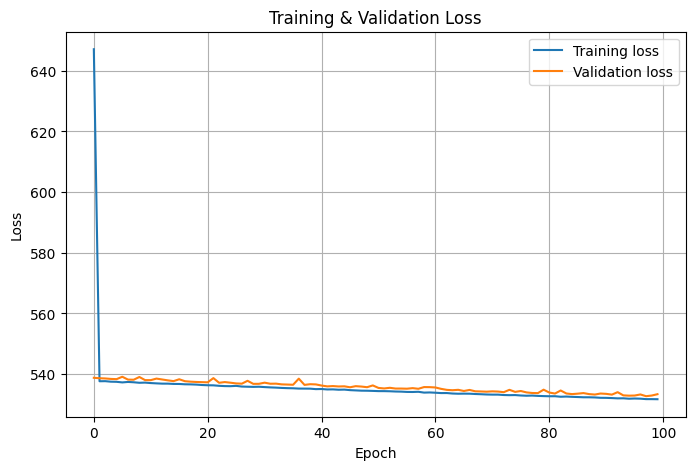

Model training finished.

Training Complete!
Final model saved to: nfl_predictor_final.keras
Best model saved to: best_model.keras

Training Summary:
  Final training loss: 531.7183
  Final validation loss: 533.3738


KeyError: 'mae'

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, metrics
import os
import sys

# Add the manual_data_processing directory to the path
# sys.path.insert(0, os.path.join(os.path.dirname(__file__), 'manual_data_processing'))

# from csv_to_numpy import NFLDataLoader, create_tf_datasets

def build_seq2seq_model(input_seq_length, input_features, output_seq_length, output_features, lstm_units=256):
    """
    Builds a sequence-to-sequence model with LSTM layers.

    Args:
        input_seq_length (int): The length of input sequences (time steps).
        input_features (int): The number of input features per timestep.
        output_seq_length (int): The length of output sequences (time steps).
        output_features (int): The number of output features per timestep.
        lstm_units (int): The number of units in the LSTM layers.

    Returns:
        keras.Model: The compiled Keras model.
    """

    SEED = 42
    # Encoder-decoder architecture for sequence-to-sequence prediction
    model = keras.Sequential([
        # Input layer
        keras.layers.Input(shape=(input_seq_length, input_features)),
        
        # Encoder LSTM layers
        keras.layers.LSTM(
            units=256,
            return_sequences=True,
            seed=SEED,
        ),
        keras.layers.LSTM(
            units=256,
            return_sequences=True,
            seed=SEED,
        ),
        keras.layers.LSTM(
            units=256,
            return_sequences=True,
            seed=SEED,
        ),
        keras.layers.LSTM(
            units=256,
            return_sequences=True,
            seed=SEED,
        ),
        keras.layers.LSTM(
            units=256,
            return_sequences=True,
            seed=SEED,
        ),
        # Crop or slice to match output sequence length
        # layers.Lambda(lambda x: x[:, :output_seq_length, :]),
        # TimeDistributed dense layer for output features
        layers.TimeDistributed(
            keras.layers.Dense(units=output_features, activation="linear")
        ),
    ])

    cosine_decay = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=415000,
    alpha=1e-5,
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.00081926, global_clipnorm=1.0),
                  loss=losses.MeanSquaredError(),
                  metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()]
                  )
    
    return model

def train_model(model, train_sequence, val_sequence, epochs=100, callbacks=None):
    """
    Trains the Keras model using Keras Sequence objects.
    
    Args:
        model: The Keras model to train
        train_sequence: Training data sequence (NFLDataSequence)
        val_sequence: Validation data sequence (NFLDataSequence)
        epochs (int): Number of training epochs
        callbacks: List of Keras callbacks
    
    Returns:
        history: Training history object
    """
    if callbacks is None:
        callbacks = []
    
    # Add early stopping and model checkpoint callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    callbacks.extend([early_stopping, model_checkpoint])
    
    print("Starting model training...")
    history = model.fit(
        train_sequence,
        epochs=epochs,
        validation_data=val_sequence,
        callbacks=model_checkpoint,
        verbose=1
    )
    # -------------------------------------------------
    # Visualize training & validation loss
    # -------------------------------------------------
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'],      label='Training loss')
    plt.plot(history.history['val_loss'],  label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Model training finished.")
    return history

def main():
    """
    Main function to load data, build, and train the model.
    """
    # Configuration
    train_dir = '/home/samer/Desktop/competitions/NFL_Big_Data_Bowl_2026_dev/nfl-big-data-bowl-2026-prediction/train'
    batch_size = 64
    epochs = 100
    test_size = 0.2
    
    print("="*60)
    print("NFL Big Data Bowl 2026 - Predictor Training")
    print("="*60)
    
    # Load and prepare data
    print("\n[1/4] Loading data from CSV files...")
    loader = NFLDataLoader(train_dir)
    X, y = loader.get_aligned_data()
    
    if len(X) == 0:
        print("Error: No data loaded. Please check the data directory.")
        return
    
    print(f"\nData Summary:")
    print(f"  Total sequences: {len(X)}")
    print(f"  Sample input sequence length: {len(X[0])}")
    print(f"  Sample output sequence length: {len(y[0])}")
    print(f"  Input features per timestep: {len(X[0][0]) if len(X[0]) > 0 else 0}")
    print(f"  Output features per timestep: {len(y[0][0]) if len(y[0]) > 0 else 0}")
    
    # Create Keras Sequences with padding
    print(f"\n[2/4] Creating training and validation sequences (test_size={test_size})...")
    train_seq, val_seq = create_tf_datasets(X, y, test_size=test_size, batch_size=batch_size)
    
    if train_seq is None:
        print("Error: Failed to create training sequences.")
        return
    
    # Get one batch to determine shapes
    x_sample, y_sample = train_seq[0]
    input_seq_length = x_sample.shape[1]
    input_features = x_sample.shape[2]
    output_seq_length = y_sample.shape[1]
    output_features = y_sample.shape[2]
    
    print(f"\nSequence Shapes:")
    print(f"  Input: (batch_size, {input_seq_length}, {input_features})")
    print(f"  Output: (batch_size, {output_seq_length}, {output_features})")
    
    # Build model
    print(f"\n[3/4] Building sequence-to-sequence model...")
    model = build_seq2seq_model(
        input_seq_length=input_seq_length,
        input_features=input_features,
        output_seq_length=output_seq_length,
        output_features=output_features,
        lstm_units=256,
    )
    
    print("\nModel Architecture:")
    model.summary()
    
    # Train model
    print(f"\n[4/4] Training model for {epochs} epochs...")
    history = train_model(model, train_seq, val_seq, epochs=epochs)
    
    # Save the final model
    final_model_path = 'nfl_predictor_final.keras'
    model.save(final_model_path)
    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Final model saved to: {final_model_path}")
    print(f"Best model saved to: best_model.keras")
    print(f"{'='*60}")
    
    # Print training summary
    print(f"\nTraining Summary:")
    print(f"  Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"  Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"  Final training MAE: {history.history['mae'][-1]:.4f}")
    print(f"  Final validation MAE: {history.history['val_mae'][-1]:.4f}")
    print(f"  Best validation loss: {min(history.history['val_loss']):.4f}")

if __name__ == '__main__':
    main()